<a href="https://colab.research.google.com/github/prithwis/parashar21/blob/main/P21_45_10_MultiChart_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://1.bp.blogspot.com/_5QlanosqxiQ/SXLOLTu7S7I/AAAAAAAAAm8/0r6C7lCxsic/S1600-R/p21-header-003.png) <br>


---



[Prithwis Mukerjee](http://www.yantrajaal.com) ||
Website - [Parashar21](https://parashar21.blogspot.com)<br>

Copyright (c) 2022, Prithwis Mukerjee
All rights reserved.

This source code is licensed under the GNU GPL v3.0 -style license found in the
LICENSE file in the root directory of this source tree.

#Cast, Store, Retrieve and Print Multiple Horoscope Charts
For ease of use & demonstration a MongoDB database is installed in the Colab VM. In a production scenario, this MongoDB database can be on an independent hosting platform that can be accessed with appropriate credentials. <br><br>
For complete information about this project see the [Parashar21](https://prithwis.github.io/parashar21/) github page.

In [1]:
from datetime import datetime
import pytz
print("\033[1m"+'ॐ श्री गणेशाय नमः'+"\033[0m")
print(datetime.now(pytz.timezone('Asia/Calcutta')))

ॐ श्री गणेशाय नमः
2023-08-09 18:47:53.110598+05:30


#Environment Setup

In [2]:
!python --version
!lsb_release -a

!pip -qq install pyswisseph                                 # https://stackoverflow.com/questions/64277506/pip-install-options-unclear
!pip -qq install python-docx                                # https://python-docx.readthedocs.io/en/latest/
!pip -qq install pymongo                                    # Required for Mongo client

Python 3.10.12
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.2 LTS
Release:	22.04
Codename:	jammy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 603.6/603.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 7.4 MB/s eta 0:00:00


In [3]:
#Utility functions
from pymongo import MongoClient
import pandas as pd
import dateutil
import json
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from datetime import datetime
from datetime import timedelta
import pytz
from google.colab import files


## Local MongoDB

In [4]:
# Installation of local MongoDB
# --------------------
!curl -fsSL https://pgp.mongodb.com/server-6.0.asc | \
   sudo gpg -o /usr/share/keyrings/mongodb-server-6.0.gpg \
   --dearmor
# --------------------
!echo "deb [ arch=amd64,arm64 signed-by=/usr/share/keyrings/mongodb-server-6.0.gpg ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse" | sudo tee /etc/apt/sources.list.d/mongodb-org-6.0.list
# --------------------
!sudo apt-get update > /dev/null
# --------------------
!sudo apt-get install -y mongodb-org > /dev/null          # error, warning messages may be ignored
# --------------------
!sudo mkdir -p /var/log/mongodb /var/lib/mongodb
# --------------------
!sudo chown `whoami` /var/lib/mongodb /var/log/mongodb/
#
#!service mongodb start                                      # start Local MongoDB server instance --- does not work anymore
!nohup mongod --config /etc/mongod.conf &                    # patch for manual start
#!mongod --version
# Connect to local MongoDB
mongoURI = "mongodb://localhost:27017/"                               # for local server
client = MongoClient(mongoURI)
#db = client.parashar21
client.list_database_names() # ['admin', 'config', 'local']

deb [ arch=amd64,arm64 signed-by=/usr/share/keyrings/mongodb-server-6.0.gpg ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 9.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
nohup: appending output to 'nohup.out'


['admin', 'local']

In [5]:
# MongoImport Module   - earlier part of MongoDB not part of database tools

# https://www.mongodb.com/try/download/database-tools
# https://www.mongodb.com/docs/database-tools/installation/installation-linux/

#!wget https://fastdl.mongodb.org/tools/db/mongodb-database-tools-ubuntu2004-x86_64-100.7.0.tgz
!wget -q -O mongodb-database-tools.deb https://fastdl.mongodb.org/tools/db/mongodb-database-tools-ubuntu2004-x86_64-100.7.0.deb
#!tar -xvf /content/mongodb-database-tools-ubuntu2004-x86_64-100.7.0.tgz
!sudo apt install ./mongodb-database-tools.deb > /dev/null



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


##Install Swiss Ephemeris <br>

https://pypi.org/project/pyswisseph/  - Python Package Documentation <br>
https://www.astro.com/swisseph/swephinfo_e.htm <br>
https://www.astro.com/swisseph/swephprg.htm - Programmer Documentation

In [6]:
#Download Swiss Ephemeris Files
!wget -q http://www.astro.com/ftp/swisseph/ephe/seas_18.se1
!wget -q http://www.astro.com/ftp/swisseph/ephe/semo_18.se1
!wget -q http://www.astro.com/ftp/swisseph/ephe/sepl_18.se1
!mkdir ephe
!mv *.se1 ephe

## Install Parashar21 Utilities

In [7]:
#Load p21 modules from github

!wget -O p21.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21.py                  # all global variables
!wget -O p21utils.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utils.py        # large number of utility functions
!wget -O p21utilsR.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utilsR.py      # report writing utility functions
!wget -O p21swe.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21swe.py            # Swiss Ephemeris functions
!wget -O p21YogInfo.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21YogInfo.py    # yog data - description and conditions
# ---------------------------

!wget -O Saraswati.png -q https://github.com/prithwis/parashar21/raw/main/images/Saraswati02.png
!wget -O p21logo.png -q https://github.com/prithwis/parashar21/raw/main/images/p21logo-002-1.png


In [8]:
# ---------------------------
import p21
import p21swe
import p21utils
import p21utilsR
import p21YogInfo
# ------------------------------------------------
# required for multiple imports of the same module
# ------------------------------------------------
import importlib
importlib.reload(p21)
importlib.reload(p21swe)
importlib.reload(p21utils)
importlib.reload(p21utilsR)
importlib.reload(p21YogInfo)

10 Yogs on record
0 : Amala Yog | 10th from Moon OR Lagna should have a benefic
1 : RajLakshana Yog | Jupiter, Venus, Mercury, Moon should be in Lagna or they should be in a Kendra
2 : Chatussagara Yog | All the Kendras 1/4/7/10 are occupied by planets, Ra, Ke not counted here
3 : Adhi678 Yog | Benefics located in 6/7/8th  from Moon
4 : Chandra Mangal Yog | Mars Conjoins Moon or  Mars and Moon in Mutual Aspect
5 : Kemadruma Yog : No planets on either sides of the Moon
6 : Anapha Yog |Planets other than Sun in 12th Place from Moon
7 : Sunapha Yog |Planets other than Sun in 2nd Place from Moon
8 : Dhurdhura Yog | Planets on both sides of the Moon
9 : Gajakesari Yog | Jupiter is in Kendra or 1,4,7,10th from Moon
10 Yogs on record
0 : Amala Yog | 10th from Moon OR Lagna should have a benefic
1 : RajLakshana Yog | Jupiter, Venus, Mercury, Moon should be in Lagna or they should be in a Kendra
2 : Chatussagara Yog | All the Kendras 1/4/7/10 are occupied by planets, Ra, Ke not counted here
3 :

<module 'p21YogInfo' from '/content/p21YogInfo.py'>

In [9]:
# Define MongoDB database
db = client.parashar21
# Configure SWE with appropriate parameters
#
p21swe.C01_configSWE()

##Read External Data
test data from CSV files


In [10]:
import pandas as pd

#!wget -O peopleData.csv -q https://raw.githubusercontent.com/prithwis/parashar21/main/data/Test5Data.txt # 5 Person Test Data
!wget -O peopleData.csv -q https://github.com/prithwis/parashar21/raw/main/data/Rodden39663.csv

#!gdown -O peopleData.csv https://drive.google.com/uc?id=1CVo1gnMZyCD0EZvAoF_wRdTwL7yqIT6L # 5 Person Test Data
#!gdown -O peopleData.csv https://drive.google.com/uc?id=1dlvqcygJJh0CfyY_X2MLrWm-W9U0z_6l # 39663 Rodden Data

df = pd.read_csv('peopleData.csv')
df.head()

,Gender,tag1,tag2,tag3,tag4,tag5,tag6,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_Off,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name
0,M,Entertain/Music,Instrumentalist (Guitarist),Entertain/Music,Song writer,Entertain/Music,"Vocalist/ Pop, Rock, etc.",6,10,1968,17:35,h1e,1.0,48.550000,3.300000,MET,standard,A_Dominique
1,M,Writers,Columnist/ journalist,Writers,Detective/ Mystery,Writers,Fiction (Novelist),19,12,1947,20:00,h1e,1.0,47.383333,0.683333,MET,standard,A_D_G_
2,M,Entertainment,Actor/ Actress,nil,nil,nil,nil,21,2,1911,03:00,h1e,1.0,59.916667,10.750000,MET,standard,Aabel_Andreas
3,M,Entertainment,Actor/ Actress,Entertainment,Voice-Over,nil,nil,25,4,1902,07:15,h1e,1.0,59.916667,10.750000,MET,standard,Aabel_Per
4,M,Entertainment,TV host/ Personality,Politics,Government employee (Minister),nil,nil,4,1,1933,12:30,h0w,-0.0,38.350000,-0.483333,GMT,standard,Aal_Pomares_Henri_Francois


#Cast Horoscope Charts in JSON format
Driver Code

In [11]:
%%time
# Basic Horoscope Information is converted into JSON format for storage on Mongo
p21.ChartType = 'Rashi'                                 # one of ['Rashi','Navamsa']
#
# Create and store the horoscope in JSON format
#
p21swe.C61_Cast2JSON(df)

1 records processed, so far
1001 records processed, so far
error on record  1715
2001 records processed, so far
3001 records processed, so far
4001 records processed, so far
5001 records processed, so far
6001 records processed, so far
7001 records processed, so far
8001 records processed, so far
9001 records processed, so far
10001 records processed, so far
11001 records processed, so far
12001 records processed, so far
13001 records processed, so far
14001 records processed, so far
15001 records processed, so far
16001 records processed, so far
17001 records processed, so far
18001 records processed, so far
19001 records processed, so far
20001 records processed, so far
21001 records processed, so far
22001 records processed, so far
23001 records processed, so far
24001 records processed, so far
25001 records processed, so far
26001 records processed, so far
27001 records processed, so far
28001 records processed, so far
error on record  28803
29001 records processed, so far
30001 re

#Load Charts into MongoDB database

In [12]:
#mongoURI = "mongodb://localhost:27017/"
client = MongoClient(mongoURI)
client.list_database_names()
#db = client.btncgfi3a5bxyea


['admin', 'config', 'local']

In [13]:
mongoURIload = mongoURI+'Parashar21'
!mongoimport --uri "{mongoURIload}"  --collection "khona21"  --drop --file "peopleData.json"

# Who was khona ?
# https://feminisminindia.com/2019/06/07/khawna-khana-poet-rural-bengal/
# https://en.wikipedia.org/wiki/Khana_(poet)

2023-08-09T13:20:24.702+0000	connected to: mongodb://localhost:27017/Parashar21
2023-08-09T13:20:24.703+0000	dropping: Parashar21.khona21
2023-08-09T13:20:27.710+0000	[##......................] Parashar21.khona21	14.3MB/137MB (10.5%)
2023-08-09T13:20:30.708+0000	[###.....................] Parashar21.khona21	21.6MB/137MB (15.8%)
2023-08-09T13:20:33.702+0000	[#####...................] Parashar21.khona21	31.7MB/137MB (23.2%)
2023-08-09T13:20:36.707+0000	[########................] Parashar21.khona21	46.5MB/137MB (34.0%)
2023-08-09T13:20:39.707+0000	[##########..............] Parashar21.khona21	61.5MB/137MB (45.0%)
2023-08-09T13:20:42.708+0000	[#############...........] Parashar21.khona21	76.2MB/137MB (55.7%)
2023-08-09T13:20:45.703+0000	[##############..........] Parashar21.khona21	83.5MB/137MB (61.1%)
2023-08-09T13:20:48.710+0000	[################........] Parashar21.khona21	93.5MB/137MB (68.5%)
2023-08-09T13:20:51.702+0000	[###################.....] Parashar21.khona21	109MB/137MB (79.5%)

##Check Database Status

In [14]:
db = client.Parashar21
p21.kollection = db.khona21
#kollection = db.khona21Test
countFinal = p21.kollection.count_documents({})
dbSizeFinal = db.command( {"dbStats": 1, "scale": 1024 } )['dataSize']
print(round(dbSizeFinal),'KB database with ', countFinal, ' docs in current collection' )

p21.kollection = db.khona21                   # Set the collection to work with
totalCharts = p21.kollection.count_documents({})
print(totalCharts)

146579 KB database with  39661  docs in current collection
39661


In [15]:
# Check data loaded into MongoDb
#c = kollection.find()
#for crnt in c:
#    print(crnt)
pd.DataFrame(list(p21.kollection.find({},{'_id':0}).limit(2)))

,pid,GLon,GRet,BhavN,BhavA,Lord,LordRashiN,LordRashiA,GrahaLordBhav,GRashiN,...,inEnemyL,GAspects2,GAspectedBy2,BAspectedBy2,BAspectedByBL2,GConjunctsG2,BLConjunctsG2,BLConjunctsBL2,beneficG,maleficG
0,"{'tags': ['Entertain/Music', 'Entertain/Music'...","{'La': 330.585, 'Su': 170.058, 'Mo': 352.364, ...","{'La': False, 'Su': False, 'Mo': False, 'Ma': ...","[ , 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[ , Meen, Mesh, Vrish, Mithun, Karkat, Simha, ...","[ , Ju, Ma, Ve, Me, Mo, Su, Me, Ve, Ma, Ju, Sa...","[ , 5, 5, 7, 7, 12, 6, 7, 7, 5, 5, 12, 12]","[ , Simha, Simha, Tula, Tula, Meen, Kanya, Tul...","{'Su': [6], 'Mo': [5], 'Ma': [2, 9], 'Me': [4,...","{'La': 12, 'Su': 6, 'Mo': 12, 'Ma': 5, 'Me': 7...",...,"[False, False, False, False, False, False, Fal...","{'La': ['Su', 'Ke'], 'Su': ['Mo', 'La', 'Ra', ...","{'Su': ['Mo', 'La', 'Ra', 'Sa'], 'Ke': ['Mo', ...","{'7': ['Mo', 'La', 'Ra', 'Sa'], '1': ['Su', 'K...","{'1': ['9', '6', '2'], '2': ['4', '3', '10', '...","{'Su': ['Ke'], 'Ke': ['Su'], 'Mo': ['Ra', 'Sa'...","{'1': ['Ma'], '2': ['Ju'], '3': ['Me'], '4': [...","{'1': ['9', '2'], '2': ['1', '10'], '3': ['4',...","{'Su': False, 'Mo': True, 'Ma': True, 'Me': Fa...","{'Su': True, 'Mo': False, 'Ma': False, 'Me': F..."
1,"{'tags': ['Writers', 'Writers', 'Writers'], 'c...","{'La': 100.281, 'Su': 243.912, 'Mo': 323.344, ...","{'La': False, 'Su': False, 'Mo': False, 'Ma': ...","[ , 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3]","[ , Karkat, Simha, Kanya, Tula, Vrishchik, Dha...","[ , Mo, Su, Me, Ve, Ma, Ju, Sa, Sa, Ju, Ma, Ve...","[ , 11, 9, 8, 10, 5, 8, 4, 4, 8, 5, 10, 8]","[ , Kumbh, Dhanu, Vrishchik, Makar, Simha, Vri...","{'Su': [2], 'Mo': [1], 'Ma': [5, 10], 'Me': [3...","{'La': 4, 'Su': 9, 'Mo': 11, 'Ma': 5, 'Me': 8,...",...,"[False, False, False, False, False, False, Fal...","{'La': ['Ve'], 'Mo': ['Ma'], 'Ma': ['Ju', 'Mo'...","{'Ve': ['La', 'Sa'], 'Ma': ['Mo'], 'Mo': ['Ma'...","{'7': ['La', 'Sa'], '12': ['Su'], '2': ['Mo'],...","{'1': ['4', '9', '6', '11'], '2': ['1'], '3': ...","{'Me': ['Ju'], 'Ju': ['Me']}","{'3': ['Ju'], '6': ['Me'], '9': ['Me'], '12': ...","{'3': ['9', '6'], '6': ['3', '12'], '9': ['3',...","{'Su': False, 'Mo': True, 'Ma': True, 'Me': Fa...","{'Su': False, 'Mo': False, 'Ma': False, 'Me': ..."


#Retrieval of Data

## Report Generation

In [16]:
def genReport(yText, ChartStyle,Sample = True):

    if Sample:
        df4Report = df.sample(5)
    else:
        df4Report = df

    selectedCharts = len(df)
    printCharts = len(df4Report)
    #printStatus = str(printCharts)+' charts of total '+str(totalCharts)+' printed.'
    printStatus = str(len(df))+' charts of total '+str(totalCharts)+' selected and '+str(printCharts)+' printed'



    now = datetime.now(pytz.timezone('Asia/Kolkata'))
    fileName = 'p21Yog_'+yText[0:4]+'_'+ChartStyle[0:1]+'_'+now.strftime("%H%M%S")+'.doc'
    curQueryStr = json.dumps(selCond)[0:100]
    # ---------------------------------------------------------
    p21utilsR.R01_CreateReportDoc(yText,printStatus)                      # Creates MS Word Doc called p21.document
    # ----------------------------------------------------------
    for chart in range(len(df4Report)):
        chartData =df4Report.iloc[chart]
        #R51_processChart(chartData)
        p21utilsR.R511_parseChartData(chartData)              # Break up database data into useful pieces
                                                              # Creates two primary dicts, GLon, GRet
        p21utilsR.R30_LocateYogs()

        for ctype in ['Rashi','Navamsa']:
        #for ctype in ['Rashi']:
            p21.ChartType = ctype
            p21utils.R11_LocateGrahaInRashi()   # Converts Graha Long to Rashi positions
                                                # Rashi Num as well as Rashi name
            if ChartStyle == 'Bengal':
                p21utilsR.R12B_drawChart_Bengal()    # Draw Chart in Bengal style
            if ChartStyle == 'South':
                p21utilsR.R12B_drawChart_South()    # Draw Chart in South style
            if ChartStyle == 'North':
                p21utilsR.R12B_drawChart_North()    # Draw Chart in North style
            #


        p21utilsR.R512_FormatPage()
        #print('----')
    # ------------------------------------
    p21.document.save(fileName)
    return fileName

print('Tested on ',datetime.now(pytz.timezone('Asia/Kolkata')))

Tested on  2023-08-09 18:50:58.195151+05:30


## Yogs Identified by BV Raman

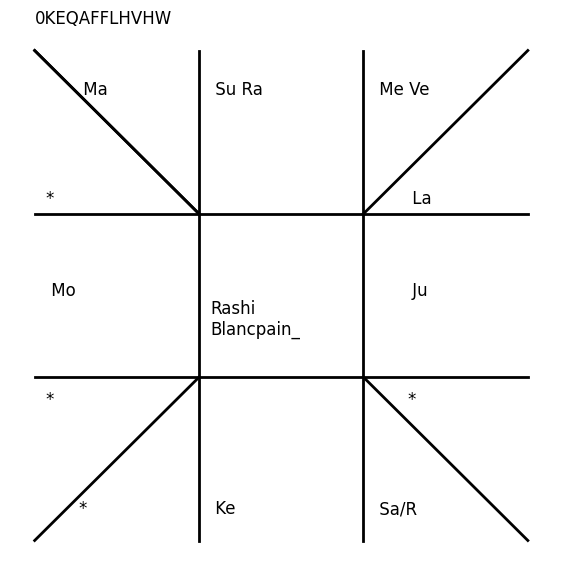

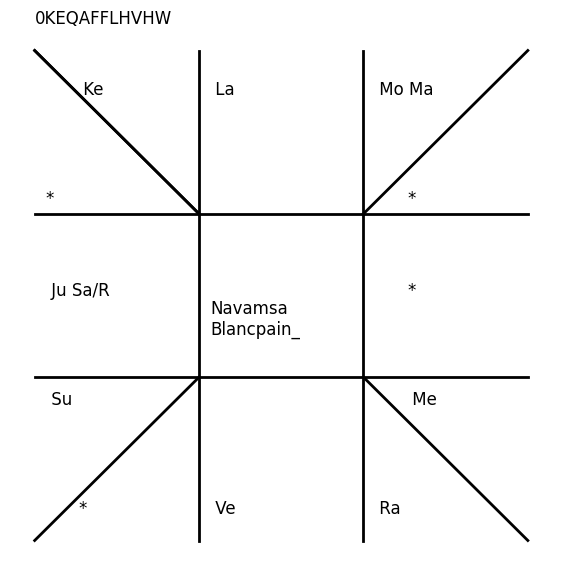

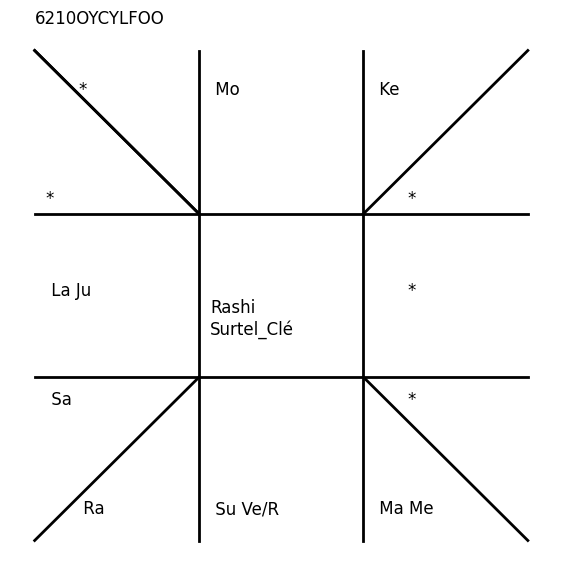

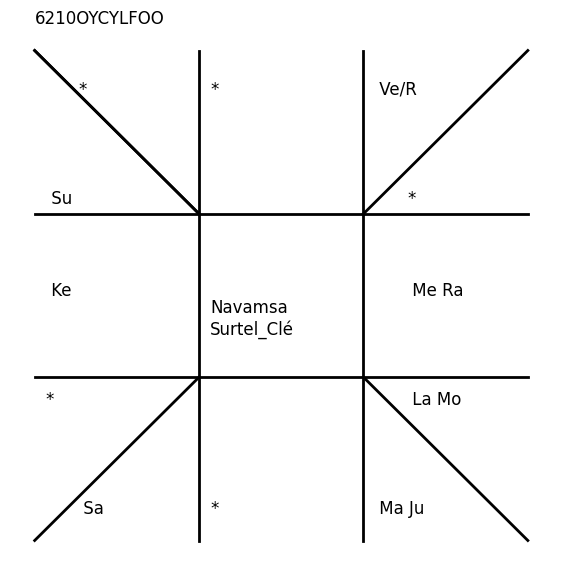

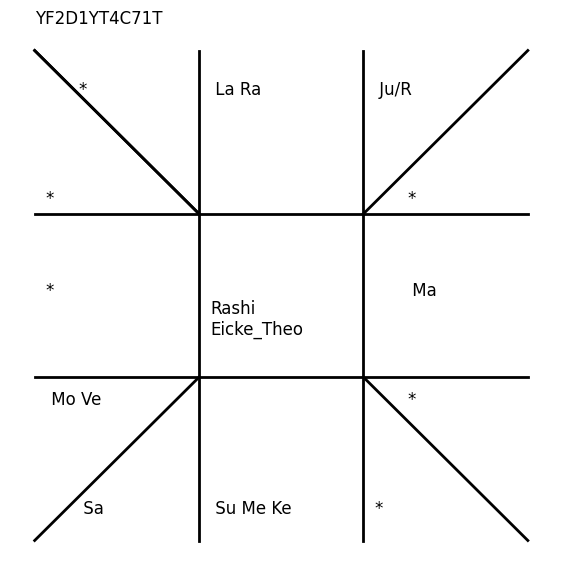

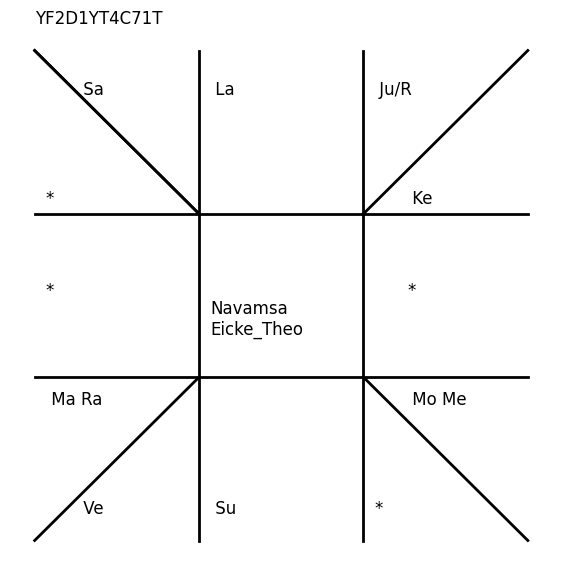

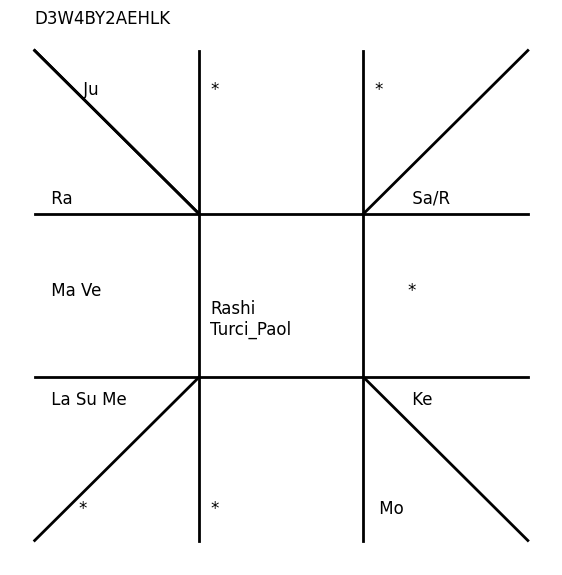

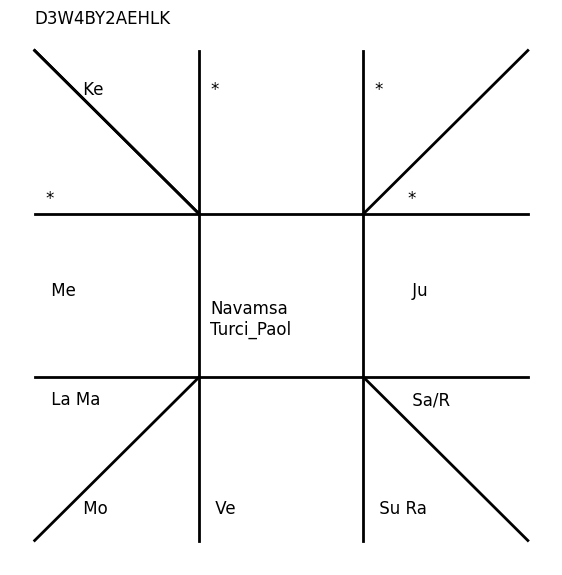

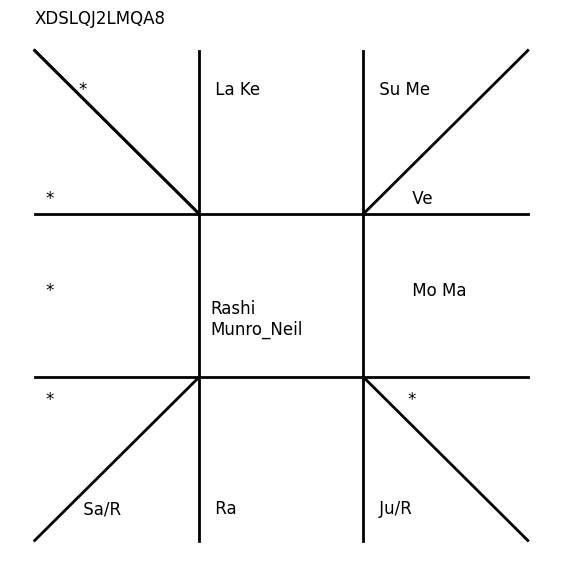

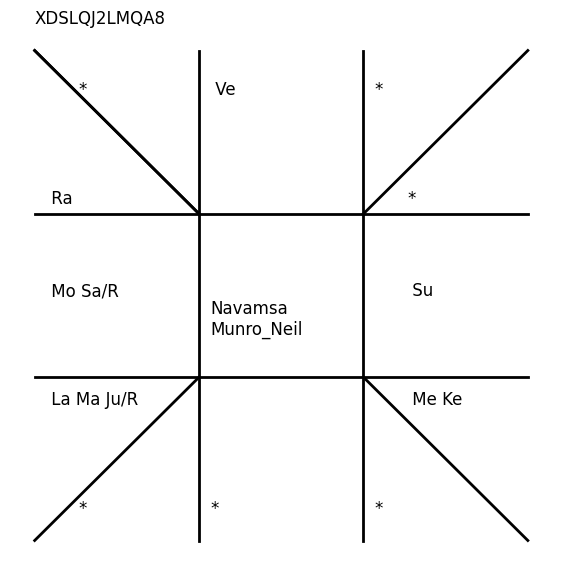

In [17]:
%%capture
yogName = 'Amala'
selCond = p21YogInfo.yogCond[yogName]
df = pd.DataFrame(list(p21.kollection.find(p21YogInfo.yogCond[yogName],p21.selCols)))
if (len(df) > 0):
    ReportFile = genReport(p21YogInfo.yogText[yogName],'Bengal')
else:
    print('no charts found')

In [20]:
%%capture
yogName = 'RajLakshana'
selCond = p21YogInfo.yogCond[yogName]
df = pd.DataFrame(list(p21.kollection.find(p21YogInfo.yogCond[yogName],p21.selCols)))
if (len(df) > 0):
    ReportFile = genReport(p21YogInfo.yogText[yogName],'Bengal')
else:
    print('no charts found')

In [ ]:
%%capture
yogName = 'Chatussagara'
selCond = p21YogInfo.yogCond[yogName]
df = pd.DataFrame(list(p21.kollection.find(p21YogInfo.yogCond[yogName],p21.selCols)))
if (len(df) > 0):
    ReportFile = genReport(p21YogInfo.yogText[yogName],'Bengal')
else:
    print('no charts found')

In [ ]:
%%capture
yogName = 'Adhi678'
selCond = p21YogInfo.yogCond[yogName]
df = pd.DataFrame(list(p21.kollection.find(p21YogInfo.yogCond[yogName],p21.selCols)))
if (len(df) > 0):
    ReportFile = genReport(p21YogInfo.yogText[yogName],'Bengal')
else:
    print('no charts found')

In [ ]:
%%capture
yogName = 'ChandraMangal'
selCond = p21YogInfo.yogCond[yogName]
df = pd.DataFrame(list(p21.kollection.find(p21YogInfo.yogCond[yogName],p21.selCols)))
ReportFile = genReport(p21YogInfo.yogText[yogName],'Bengal')

In [ ]:
%%capture
yogName = 'ChandraMangal2'
selCond = p21YogInfo.yogCond[yogName]
df = pd.DataFrame(list(p21.kollection.find(p21YogInfo.yogCond[yogName],p21.selCols)))
ReportFile = genReport(p21YogInfo.yogText[yogName],'Bengal')

In [ ]:
%%capture
yogName = 'ChandraMangal1'
selCond = p21YogInfo.yogCond[yogName]
df = pd.DataFrame(list(p21.kollection.find(p21YogInfo.yogCond[yogName],p21.selCols)))
ReportFile = genReport(p21YogInfo.yogText[yogName],'Bengal')

In [ ]:
%%capture
yogName = 'Kemadruma'
selCond = p21YogInfo.yogCond[yogName]
df = pd.DataFrame(list(p21.kollection.find(p21YogInfo.yogCond[yogName],p21.selCols)))
ReportFile = genReport(p21YogInfo.yogText[yogName],'Bengal')

In [ ]:
%%capture
yogName = 'Dhurdhura'
selCond = p21YogInfo.yogCond[yogName]
df = pd.DataFrame(list(p21.kollection.find(p21YogInfo.yogCond[yogName],p21.selCols)))
ReportFile = genReport(p21YogInfo.yogText[yogName],'Bengal')

In [ ]:
%%capture
yogName = 'Anapha'
selCond = p21YogInfo.yogCond[yogName]
df = pd.DataFrame(list(p21.kollection.find(p21YogInfo.yogCond[yogName],p21.selCols)))
ReportFile = genReport(p21YogInfo.yogText[yogName],'Bengal')

In [ ]:
%%capture
yogName = 'Sunapha'
selCond = p21YogInfo.yogCond[yogName]
df = pd.DataFrame(list(p21.kollection.find(p21YogInfo.yogCond[yogName],p21.selCols)))
ReportFile = genReport(p21YogInfo.yogText[yogName],'Bengal')

## Random Search Patterns

In [21]:
%%capture
selCond = {'GAspectedBy2.La': {'$in': ['Sa']}}                      # La aspected by Sa
df = pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols)))
tag = 'Testing : '+json.dumps(selCond)
ReportFile = genReport(tag,'Bengal')

In [ ]:
%%capture
selCond = {"$and":
                    [
                        {'exaltG.Ju': {'$eq': True}},               # Exalted Jupiter
                        {'GAspectedBy2.La' : {'$in': ['Sa']}}       # La aspected by Sa

                    ]
}

df = pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols)))
tag = 'Testing : '+json.dumps(selCond)
ReportFile = genReport(tag,'Bengal')

In [22]:
%%capture
selCond = {"$and":
                    [
                        {'exaltG.Ju': {'$eq': True}},               # Exalted Jupiter
                        {'GAspectedBy2.La' : {'$in': ['Sa']}} ,     # La aspected by Sa
                        {'GConjunctsG2.Su' : {'$in': ['Me']}}       # Su conjunct Me

                    ]
}

df = pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols)))
tag = 'Testing : '+json.dumps(selCond)
ReportFile = genReport(tag,'North')

In [ ]:
%%capture
selCond = {"$and":
                    [
                        {'exaltG.Ju': {'$eq': True}},               # Exalted Jupiter
                        {'GAspectedBy2.La' : {'$in': ['Sa']}} ,     # La aspected by Sa
                        {'GConjunctsG2.Su' : {'$in': ['Me']}},      # Su conjunct Me
                        {'GrahaBhava.Mo' : {'$eq': 1}}              # Mo in First House
                    ]
}

df = pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols)))
tag = 'Testing : '+json.dumps(selCond)
ReportFile = genReport(tag,'North')

In [23]:
%%capture
selCond = {"$and":
                    [
                        {'exaltG.Ju': {'$eq': True}},               # Exalted Jupiter
                        {'GAspectedBy2.La' : {'$in': ['Sa']}} ,     # La aspected by Sa
                        {'GConjunctsG2.Su' : {'$in': ['Me']}},      # Su conjunct Me
                        {'GrahaBhava.Mo' : {'$eq': 1}} ,            # Mo in First House
                        {'LordBhav.4' : {'$eq': 5}}                 # 4th Lord in 5th House
                    ]
}
df = pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols)))
tag = 'Testing : '+json.dumps(selCond)
ReportFile = genReport(tag,'South',False)

#End

In [24]:
print("\033[1m"+'ॐ श्री गणेशाय नमः'+"\033[0m")
print(datetime.now(pytz.timezone('Asia/Calcutta')))

ॐ श्री गणेशाय नमः
2023-08-09 19:03:53.484978+05:30


#Chronobooks <br>
![alt text](https://1.bp.blogspot.com/-lTiYBkU2qbU/X1er__fvnkI/AAAAAAAAjtE/GhDR3OEGJr4NG43fZPodrQD5kbxtnKebgCLcBGAsYHQ/s600/Footer2020-600x200.png)<hr>
Chronotantra and Chronoyantra are two science fiction novels that explore the collapse of human civilisation on Earth and then its rebirth and reincarnation both on Earth as well as on the distant worlds of Mars, Titan and Enceladus. But is it the human civilisation that is being reborn? Or is it some other sentience that is revealing itself.
If you have an interest in AI and found this material useful, you may consider buying these novels, in paperback or kindle, from [http://bit.ly/chronobooks](http://bit.ly/chronobooks)

#Redundant Stuff
too scared to throw it away!

In [19]:
#Retrieves Charts based on tags
pd.DataFrame(list(p21.kollection.find({'pid.tags': {"$in": ['Scientist','Author']}},{'pid.tags':1,'GLon':1,'GRet':1,'_id':0})))
c = p21.kollection.find({'pid.tags': {"$in": ['Scientist','Author']}},{'pid.tags':1,'GLon':1,'GRet':1,'_id':0})
for crnt in c:
    print(crnt)